# Figure 002 (v001)

"Confounding" molecular and cell line covariates.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from typing import Sequence

import janitor  # noqa: F401
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

In [3]:
import speclet.plot as sp
from speclet.io import DataFile, data_path, figure_img_file, tables_dir
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sp.set_speclet_theme(sp.PlottingMode.DISSERTATION)

In [5]:
FIGNUM, VERSION = 2, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "molecular-cell-covariates")
FIGURE_FILE

PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/figures/figure_002-v001/fig_002-v001_molecular-cell-covariates.png')

In [6]:
notebook_output_dir = tables_dir() / "100_106_molecular-cellular-covariates"

### Data

In [7]:
cell_effects = pd.read_csv(notebook_output_dir / "cell-effects.csv")
chrom_effects = pd.read_csv(notebook_output_dir / "chromosome-effects.csv")
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

## Figure

### Shared

In [8]:
FIGSIZE = (6.5, 7)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(nrows=2, ncols=1, squeeze=True, height_ratios=(1.75, 1))

top_panel_subfigs = subfigures[0].subfigures(nrows=1, ncols=2, width_ratios=(1, 2))
panels_ac = top_panel_subfigs[0].subfigures(nrows=2, height_ratios=(1, 1))
panel_a = panels_ac[0]
panel_c = panels_ac[1]

panel_b = top_panel_subfigs[1]

bottom_row_subfigs = subfigures[1].subfigures(ncols=3, width_ratios=(1, 2, 2))
panel_d = bottom_row_subfigs[0]
panel_e = bottom_row_subfigs[1]
panel_f = bottom_row_subfigs[2]

<Figure size 650x700 with 0 Axes>

### a. Joint intercept and CN slope for cell lines

In [9]:
panel_a.clear()
panel_a.text(0, 0.96, "a", fontsize=8, fontweight="bold")

gs = panel_a.add_gridspec(
    nrows=2, ncols=2, width_ratios=(7, 1), height_ratios=(1, 7), wspace=0.0, hspace=0.0
)
ax = panel_a.add_subplot(gs[1, 0])
ax_histx = panel_a.add_subplot(gs[0, 0], sharex=ax)
ax_histy = panel_a.add_subplot(gs[1, 1], sharey=ax)

plot_df = cell_effects.pivot_wider(
    ["depmap_id", "lineage", "lineage_subtype"],
    names_from="var_name",
    values_from="mean",
).sample(frac=1, random_state=12)

ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.axvline(0, c="k", lw=0.5, zorder=1)

sns.scatterplot(
    data=plot_df,
    x="mu_k",
    y="mu_m",
    hue="lineage_subtype",
    palette=sublineage_pal,
    ax=ax,
    s=4,
    alpha=0.9,
    edgecolor=None,
    legend=False,
    zorder=20,
)
ax.set_xlabel(r"$\mu_k$, intercept")
ax.set_ylabel(r"$\mu_m$, copy number")

sns.histplot(data=plot_df, x="mu_k", binwidth=0.02, ax=ax_histx)
ax_histx.set_xlabel(None)
ax_histx.set_ylabel(None)
ax_histx.set_yticklabels([])
ax_histx.tick_params("x", labelbottom=False)
ax_histx.grid(visible=False, axis="y")

sns.histplot(data=plot_df, y="mu_m", binwidth=0.02, ax=ax_histy)
ax_histy.set_ylabel(None)
ax_histy.set_xlabel(None)
ax_histy.set_xticklabels([])
ax_histy.tick_params("y", labelleft=False)
ax_histy.grid(visible=False, axis="x")

### b. Boxplots of marginals for cells lines

In [10]:
def _get_subtype_from_text(t: str) -> str:
    if "(" not in t:
        return t
    t = t.split("(")[1].replace(")", "").strip()
    return t


def _get_subtype_from_full_label(lbl: mpl.text.Text) -> mpl.text.Text:
    lbl.set_text(_get_subtype_from_text(lbl.get_text()))
    return lbl


def get_subtypes_from_full_labels(lbls: Sequence[mpl.text.Text]) -> list[mpl.text.Text]:
    return [_get_subtype_from_full_label(lbl) for lbl in lbls]

In [11]:
lineage_counts = (
    cell_effects[["lineage", "lineage_subtype"]]
    .drop_duplicates()
    .groupby("lineage")["lineage_subtype"]
    .count()
    .reset_index()
    .rename(columns={"lineage_subtype": "n"})
)

In [12]:
panel_b.clear()
panel_b.text(0, 0.98, "b", fontsize=8, fontweight="bold")

_axes = panel_b.subplots(nrows=2, sharex=True)
ax_b, ax_c = _axes[0], _axes[1]

for ax, v in zip([ax_b, ax_c], ["mu_k", "mu_m"]):
    sns.boxplot(
        data=cell_effects.query(f"var_name == '{v}'"),
        x="lineage_subtype",
        y="mean",
        hue="lineage",
        palette=lineage_pal,
        dodge=False,
        linewidth=0.5,
        showfliers=False,
        ax=ax,
        boxprops={"zorder": 20},
        zorder=20,
    )
    ax.get_legend().remove()
    ax.set_xlabel(None)
    # ax.set_ylabel(r"$\\" + v + "$")

x = 0
angle = 60
for _, info in lineage_counts.iterrows():
    c = x + (info["n"] / 2) - 0.5 - 0.5
    x += info["n"]
    ax_b.text(c, 0.11, info["lineage"], size=6, rotation=angle, zorder=10)
    for ax in [ax_b, ax_c]:
        ax.axvline(x - 0.5, c="white", lw=1, zorder=1)

x_lbls = get_subtypes_from_full_labels(ax_c.get_xticklabels())
ax_c.set_xticklabels(labels=x_lbls, rotation=angle, size=6, ha="right")
None

### c. Chromosome effects for select cell lines

In [13]:
cell_effects.query("var_name == 'mu_k' and mean < -0.15")

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage_subtype,depmap_id,lineage
16,mu_k[ACH-001843],-0.557,0.022,-0.590,-0.521,0.001,0.001,474.0,1029.0,1.01,mu_k,bile duct (cholangiocarcinoma),ACH-001843,bile duct
1281,mu_k[ACH-001031],-0.163,0.048,-0.238,-0.084,0.001,0.001,1502.0,2264.0,1.01,mu_k,soft tissue (ATRT),ACH-001031,soft tissue


In [14]:
cell_effects[["lineage", "lineage_subtype", "depmap_id"]].sample(
    n=10, random_state=2342
)

,lineage,lineage_subtype,depmap_id
986,lymphocyte,lymphocyte (non hodgkin lymphoma),ACH-000402
1140,pancreas,pancreas,ACH-000022
386,central nervous system,central nervous system (glioma),ACH-000490
800,lung,lung (NSCLC),ACH-000872
978,lymphocyte,lymphocyte (non hodgkin lymphoma),ACH-000053
607,gastric,gastric (gastric adenocarcinoma),ACH-000898
1185,peripheral nervous system,peripheral nervous system (neuroblastoma),ACH-000312
314,central nervous system,central nervous system (glioma),ACH-000098
1232,plasma cell,plasma cell (multiple myeloma),ACH-000763
879,lung,lung (NSCLC),ACH-000860


In [15]:
panel_c.clear()
panel_c.text(0, 0.98, "c", fontsize=8, fontweight="bold")

axes_c = panel_c.subplots(2, 2)

CELL_LINES = ["ACH-001843", "ACH-000980", "ACH-000223", "ACH-001328"]
for ax, cl in zip(axes_c.flatten(), CELL_LINES):
    lineage = cell_effects.query(f"depmap_id == '{cl}'")["lineage_subtype"].values[0]
    title = cl + "\n(" + _get_subtype_from_text(lineage) + ")"
    ax.set_title(title, size=6)
    ax.axhline(0, c="k", lw=0.5, zorder=1)
    ax.axvline(0, c="k", lw=0.5, zorder=1)

    chrom_df = chrom_effects.query(f"depmap_id == '{cl}'").pivot_wider(
        ["cell_chrom"],
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    ax.scatter(chrom_df["mean_k"], chrom_df["mean_m"], s=1, c="k", zorder=10)
    lines_kwargs = {"color": "k", "alpha": 0.5, "lw": 0.5, "zorder": 8}
    ax.vlines(
        x=chrom_df["mean_k"],
        ymin=chrom_df["hdi_5.5%_m"],
        ymax=chrom_df["hdi_94.5%_m"],
        **lines_kwargs,
    )
    ax.hlines(
        y=chrom_df["mean_m"],
        xmin=chrom_df["hdi_5.5%_k"],
        xmax=chrom_df["hdi_94.5%_k"],
        **lines_kwargs,
    )

    cell_df = cell_effects.query(f"depmap_id == '{cl}'").pivot_wider(
        ["depmap_id"],
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    ax.scatter(cell_df["mean_mu_k"], cell_df["mean_mu_m"], s=4, c="tab:red", zorder=20)
    lines_kwargs = {"color": "tab:red", "alpha": 0.5, "lw": 0.5, "zorder": 18}
    ax.vlines(
        x=cell_df["mean_mu_k"],
        ymin=cell_df["hdi_5.5%_mu_m"],
        ymax=cell_df["hdi_94.5%_mu_m"],
        **lines_kwargs,
    )
    ax.hlines(
        y=cell_df["mean_mu_m"],
        xmin=cell_df["hdi_5.5%_mu_k"],
        xmax=cell_df["hdi_94.5%_mu_k"],
        **lines_kwargs,
    )
    ax.tick_params(labelsize=6)

panel_c.supxlabel("intercept", fontsize=7)
panel_c.supylabel("copy number", fontsize=7)

Text(0.02, 0.5, 'copy number')

### Data for bottom row of panels

In [16]:
subfigures[1].clear()
bottom_row_subfigs = subfigures[1].subfigures(ncols=3, width_ratios=(1, 2, 4))
panel_d = bottom_row_subfigs[0]
panel_e = bottom_row_subfigs[1]
panel_f = bottom_row_subfigs[2]

In [17]:
essential_genes = set(
    pd.read_csv(data_path(DataFile.DEPMAP_ESSENTIALS))
    .query("is_essential")["gene"]
    .unique()
)
len(essential_genes)

1248

In [18]:
cn_post = (
    pd.read_csv(notebook_output_dir / "rna-copynumber-posterior-summaries.csv")
    .query("var_name == 'd'")
    .reset_index(drop=True)
    .assign(is_essential=lambda d: d["hugo_symbol"].isin(essential_genes))
)
cn_post.head(3)

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage_subtype,hugo_symbol,lineage,sgrna_target_chr,sgrna_target_pos,is_essential
0,d[A1BG],-0.108,0.090,-0.258,0.031,0.001,0.001,9749.0,3060.0,1.0,d,bile duct (cholangiocarcinoma),A1BG,bile duct,19,58352387.0,False
1,d[A1CF],-0.068,0.087,-0.210,0.069,0.001,0.001,11126.0,2494.0,1.0,d,bile duct (cholangiocarcinoma),A1CF,bile duct,10,50840175.0,False
2,d[A2M],-0.065,0.102,-0.216,0.108,0.001,0.001,9265.0,2671.0,1.0,d,bile duct (cholangiocarcinoma),A2M,bile duct,12,9104546.5,False


In [19]:
ranked_genes = pd.read_csv(notebook_output_dir / "total-ranked-genes-copynumber.csv")
ranked_genes.head(3)

,hugo_symbol,var_name,rank,is_essential
0,LSM2,b,0.965865,False
1,HAUS4,b,0.959545,True
2,PSMG4,b,0.958221,True


In [20]:
n_genes = ranked_genes["hugo_symbol"].nunique()
new_essentials = (
    pd.read_csv(notebook_output_dir / "new-essential-genes-plot-data.csv")
    .sort_values("order", ascending=False)
    .assign(order=lambda d: np.arange(len(d)))
    .assign(order=lambda d: n_genes - d["order"])
    .reset_index(drop=True)
    .sort_values("is_essential", ascending=False)
)
with open(notebook_output_dir / "new-essentials-pal.json", "r") as fp:
    new_essentials_pal = json.load(fp)

### d. Gene copy number effect for essential genes

In [21]:
panel_d.clear()
panel_d.text(0, 0.98, "d", fontsize=8, fontweight="bold")
ax = panel_d.subplots()

essential_lbls = {True: "essential", False: "other"}
essential_pal = {"essential": "tab:orange", "other": "tab:blue"}

plt_df = cn_post.copy()[["is_essential", "mean"]].assign(
    is_essential=lambda d: d["is_essential"].map(essential_lbls)
)
sns.boxplot(
    data=plt_df,
    x="is_essential",
    y="mean",
    hue="is_essential",
    palette=essential_pal,
    dodge=False,
    showfliers=False,
    linewidth=0.5,
    ax=ax,
    boxprops={"zorder": 10},
    zorder=10,
)
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(r"$\bar{d}$ posterior")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=50, ha="right")

[Text(0, 0, 'other'), Text(1, 0, 'essential')]

### e. Genes ranked by copy number effect

In [22]:
panel_e.clear()
panel_e.text(0, 0.98, "e", fontsize=8, fontweight="bold")
ax = panel_e.subplots()


plt_df = (
    ranked_genes.query("var_name == 'd'")
    .sort_values("rank", ascending=True)
    .assign(order=lambda d: np.arange(len(d)))
    .sort_values("is_essential")
    .assign(is_essential=lambda d: d["is_essential"].map(essential_lbls))
)
sns.scatterplot(
    data=plt_df,
    x="order",
    y="rank",
    hue="is_essential",
    ax=ax,
    edgecolor=None,
    s=1,
    zorder=10,
)
if leg := ax.get_legend():
    leg.remove()

ax.legend(
    handles=pal_to_legend_handles(essential_pal, lw=0, marker="o", markersize=2),
    handlelength=0,
    handletextpad=0.7,
    labelspacing=0.1,
    loc="upper left",
    bbox_to_anchor=(0, 0.9),
    frameon=True,
    edgecolor="white",
)
ax.set_xlabel("gene order")
ax.set_ylabel(r"avg. rank of gene CN effect")

ymin = new_essentials["rank"].min()
xmin = new_essentials["order"].min()
ax.axvline(xmin, c="k", linestyle="--", lw=0.5, zorder=50)
ax.axhline(ymin, c="k", linestyle="--", lw=0.5, zorder=50)

### f. "New" essential genes

In [23]:
panel_f.clear()
panel_f.text(0, 0.98, "f", fontsize=8, fontweight="bold")
ax = panel_f.subplots()

sizes = {True: 1, False: 4}

sns.scatterplot(
    data=new_essentials,
    x="order",
    y="rank",
    hue="label",
    size="is_essential",
    sizes=sizes,
    edgecolor=None,
    palette=new_essentials_pal,
    legend=False,
    ax=ax,
    zorder=10,
)

ymin, ymax = new_essentials["rank"].min(), new_essentials["rank"].max()
ax.set_ylim(ymin - (ymin * 0.003), ymax * 1.003)

texts = []
for i, row in new_essentials.iterrows():
    if not row["is_essential"]:
        if row["label"] == "essential":
            raise BaseException(f"Improperly labeled gene: '{row['hugo_symbol']}'")
        va = "top" if i % 2 == 0 else "bottom"
        dy = -1 if i % 2 == 0 else 1
        txt = ax.text(
            row["order"],
            row["rank"],  # + (dy / 1000),
            "$" + row["hugo_symbol"] + "$",
            size=4.5,
            color=new_essentials_pal[row["label"]],
            # rotation=-90,
            va="center",
            ha="center",
            zorder=20,
        )
        texts.append(txt)

np.random.seed(90)
adjust_text(
    texts,
    ax=ax,
    # autoalign=False,
    expand_text=(1.05, 1.1),
    expand_objects=(1.05, 1.05),
    expand_points=(1.05, 1.05),
    force_text=(0.2, 0.2),
    force_points=(0.1, 0.1),
    force_objects=(0.1, 0.1),
    lim=60,
    arrowprops={"arrowstyle": "-", "lw": 0.5, "color": "grey", "zorder": 18},
)

ax.legend(
    handles=pal_to_legend_handles(new_essentials_pal, lw=0, marker="o", markersize=2.5),
    loc="upper left",
    frameon=True,
    edgecolor="white",
    labelspacing=0.1,
    handletextpad=0.9,
    handlelength=0,
    fontsize=6,
)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.set_xlabel("gene order")
ax.set_ylabel(r"avg. rank of gene CN effect")

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


Text(0, 0.5, 'avg. rank of gene CN effect')

<Figure size 640x480 with 0 Axes>

## Saving

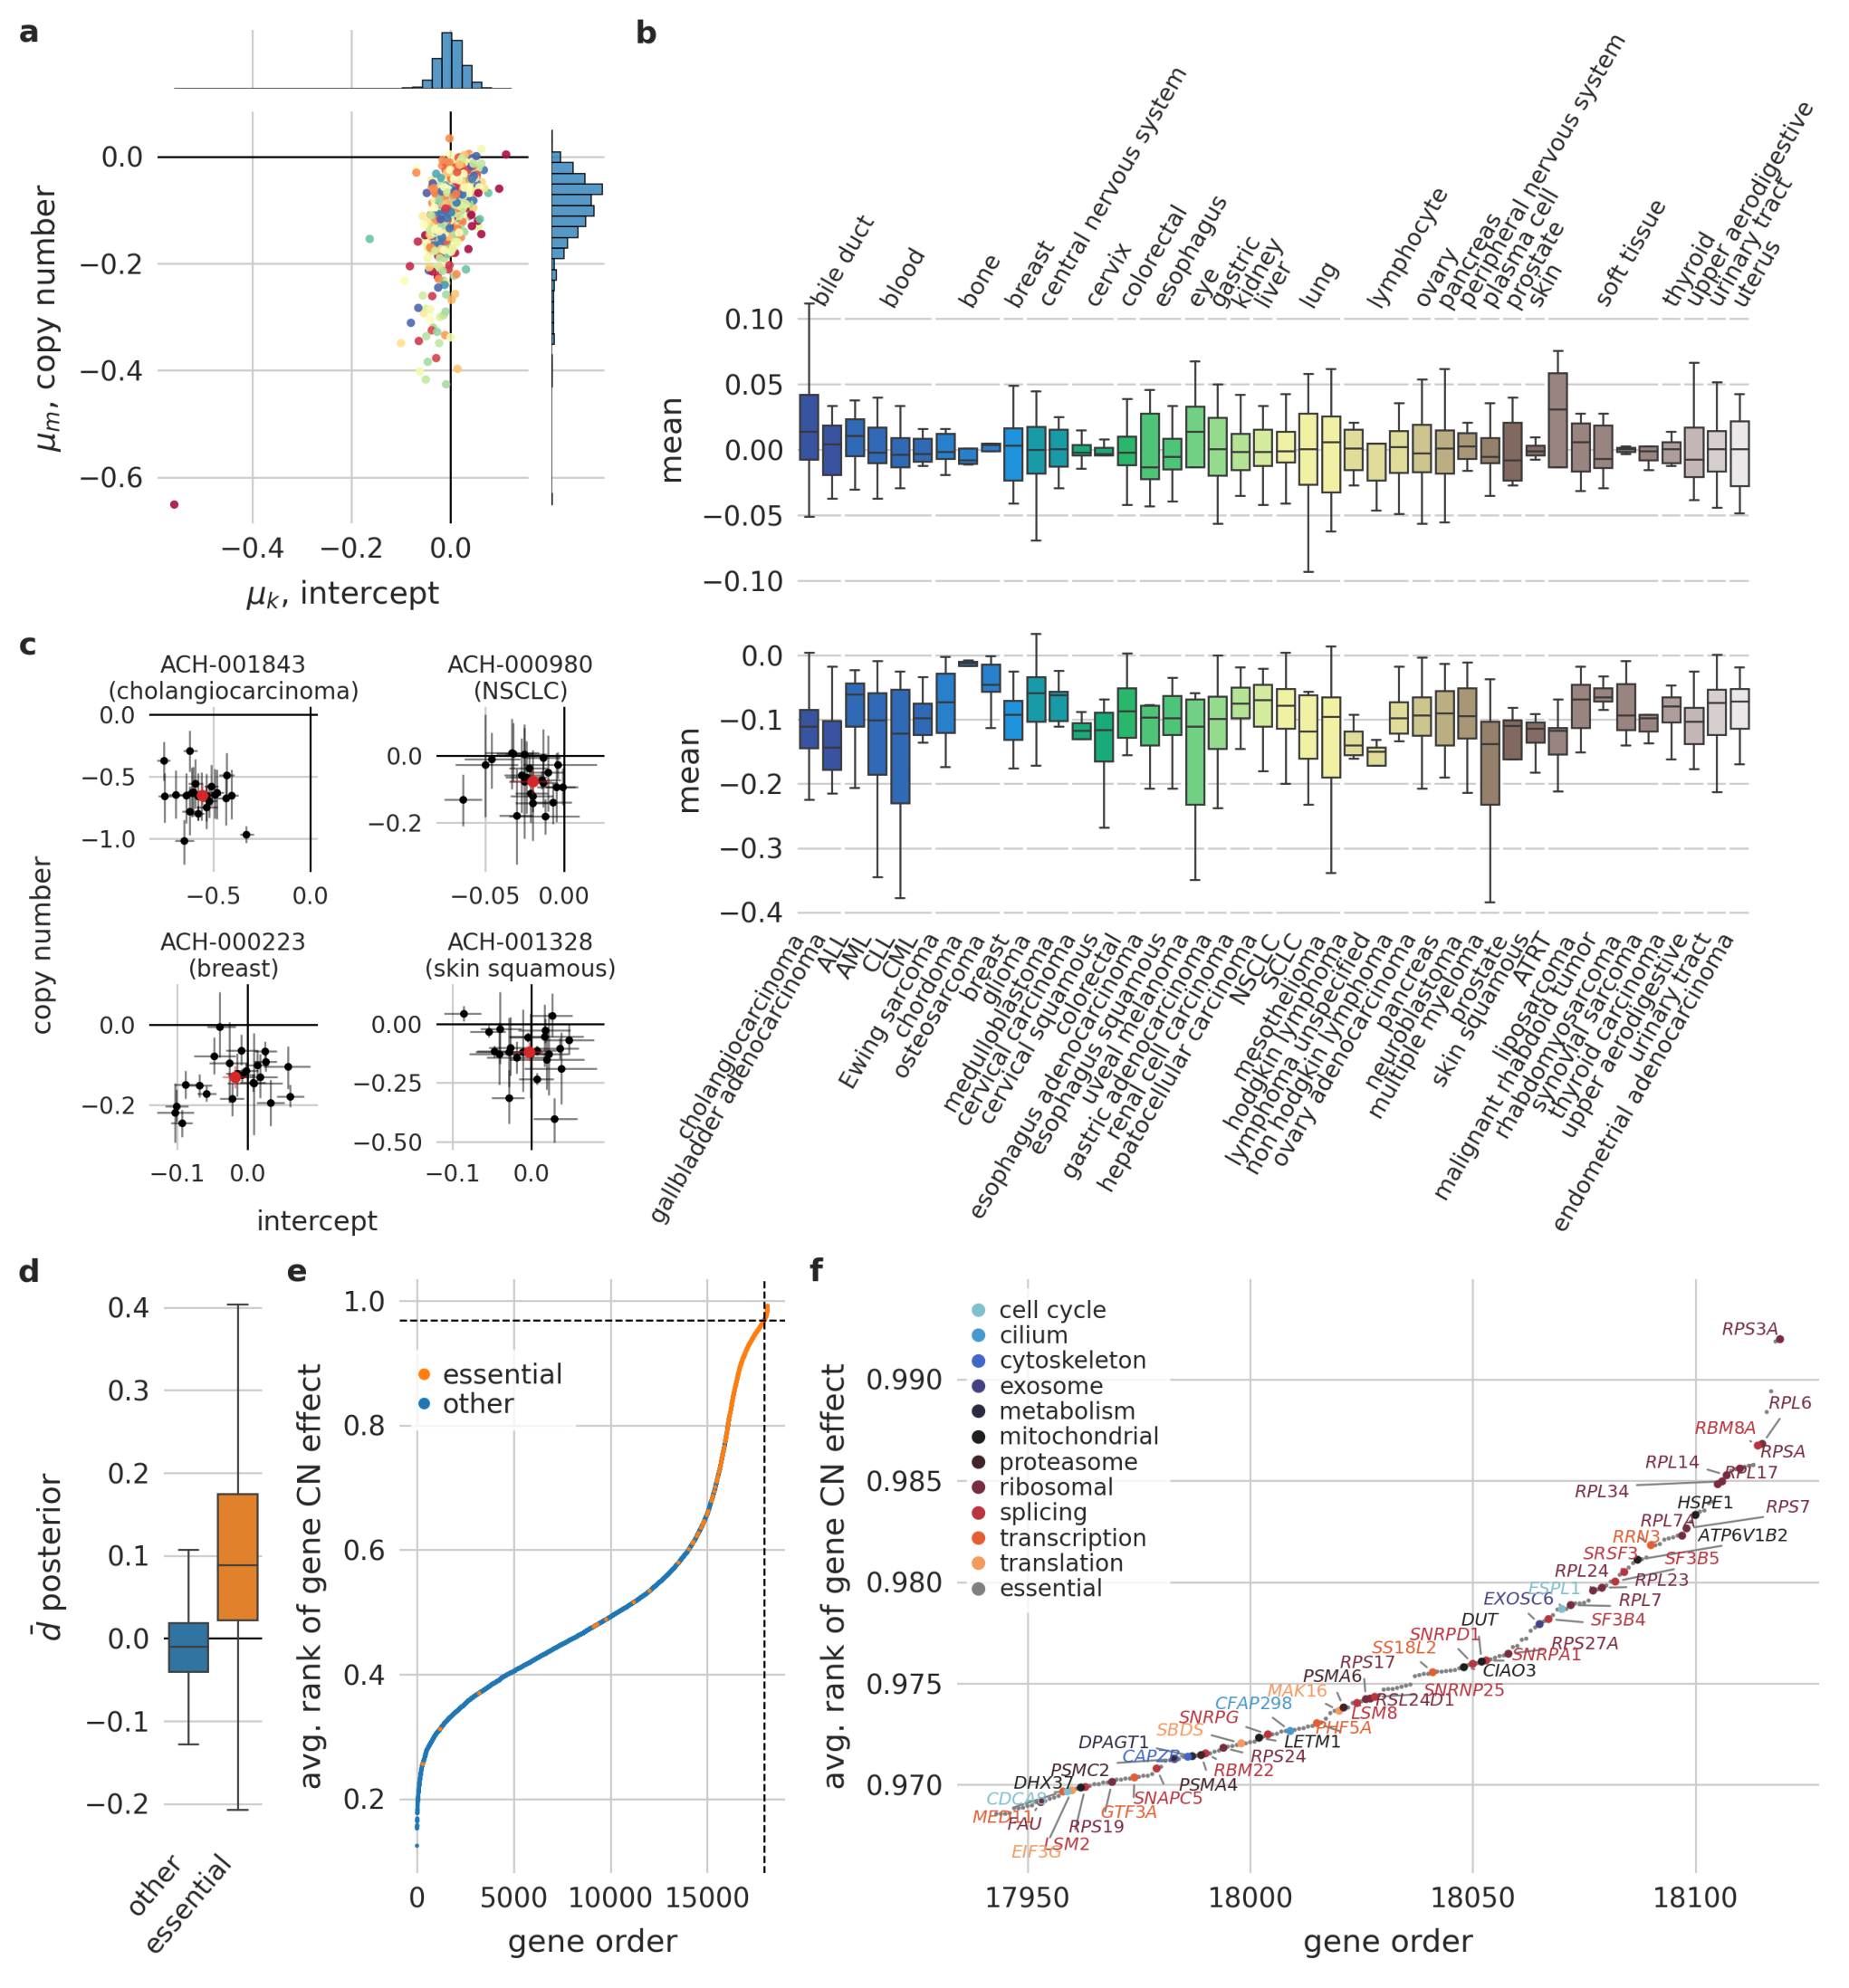

In [24]:
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0)

_, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [25]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-04

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: figures

matplotlib: 3.5.3
janitor   : 0.22.0
seaborn   : 0.11.2
pandas    : 1.4.4
json      : 2.0.9
numpy     : 1.23.3
speclet   : 0.0.9000

